In [47]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import jax.numpy as jnp
import jax

from jax.random import PRNGKey, split
from jax import config, grad
from time import time
config.update("jax_enable_x64", True)

from data import generate_data
from loss import create_l2_loss
from network import init_net, create_network, compute_prefactor
from solver import train
from utils import svd, sensing_operator

## Whitened Data

In [62]:
key = PRNGKey(0)

input_dim = 20
output_dim = 2
n_samples = 1000
depth = 3
init_type = "orth"
init_scale = 1

key, target_key = split(key)
target = generate_data(key=target_key, shape=(output_dim, n_samples))

key, input_data_key = split(key)
input_data = generate_data(key=input_data_key, shape=(input_dim, n_samples), orth=True)

key, weight_key = split(key)
init_weights = init_net(key=weight_key, input_dim=input_dim, output_dim=output_dim, width=input_dim, depth=depth, init_type="orth", init_scale=init_scale)
network_fn = create_network(pre=input_data)
l2_loss_fn = create_l2_loss(target)

In [63]:
num_iters = 1000
step_size = 1e-1
weights, loss_list, time_list = train(
    init_weights=init_weights, 
    loss_fn=l2_loss_fn, 
    network_fn=network_fn,
    n_epochs=num_iters,
    step_size=step_size, 
    n_inner_loops=1,
    factors=False,
    save_weights=False
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [64]:
V1 = compute_prefactor(init_weights=init_weights, loss_fn=l2_loss_fn, network_fn=network_fn, grad_rank=output_dim)
U1 = init_weights[0] @ V1 / init_scale
V2 = U1 
U2 = init_weights[1] @ V2 / init_scale

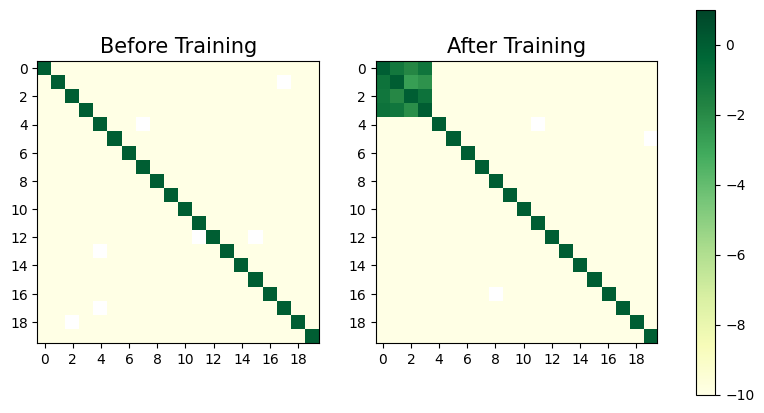

In [65]:
# Columns denote before/after training, rows denote layer
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
axes[0].imshow(jnp.log10(jnp.abs(U1.T @ init_weights[0] @ V1)), cmap='YlGn', vmax=1, vmin=-10)
axes[0].set_title('Before Training', fontsize=15)
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].yaxis.set_major_locator(MaxNLocator(integer=True))

pcm = axes[1].imshow(jnp.log10(jnp.abs(U1.T @ weights[0] @ V1)), cmap='YlGn', vmax=1, vmin=-10)
axes[1].set_title('After Training', fontsize=15)
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))

fig.colorbar(pcm, ax=axes.ravel().tolist())
plt.savefig('figs/thm1.png', dpi=300, bbox_inches='tight')

## Non-Whitened Data

In [66]:
key = PRNGKey(0)

input_dim = 20
output_dim = 2
n_samples = 1000
depth = 3
init_type = "orth"
init_scale = 1

key, target_key = split(key)
target = generate_data(key=target_key, shape=(output_dim, n_samples))

key, input_data_key = split(key)
input_data = generate_data(key=input_data_key, shape=(input_dim, n_samples), orth=False)

key, weight_key = split(key)
init_weights = init_net(key=weight_key, input_dim=input_dim, output_dim=output_dim, width=input_dim, depth=depth, init_type="orth", init_scale=init_scale)
network_fn = create_network(pre=input_data)
l2_loss_fn = create_l2_loss(target)

In [67]:
num_iters = 1000
step_size = 1e-1
weights, loss_list, time_list = train(
    init_weights=init_weights, 
    loss_fn=l2_loss_fn, 
    network_fn=network_fn,
    n_epochs=num_iters,
    step_size=step_size, 
    n_inner_loops=1,
    factors=False,
    save_weights=False
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [68]:
V1 = compute_prefactor(init_weights=init_weights, loss_fn=l2_loss_fn, network_fn=network_fn, grad_rank=output_dim)
U1 = init_weights[0] @ V1 / init_scale
V2 = U1 
U2 = init_weights[1] @ V2 / init_scale

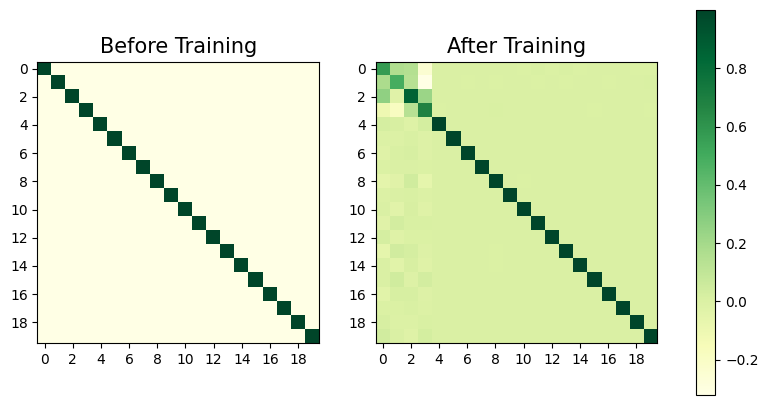

In [69]:
# Columns denote before/after training, rows denote layer
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
axes[0].imshow(U1.T @ init_weights[0] @ V1, cmap='YlGn')
axes[0].set_title('Before Training', fontsize=15)
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].yaxis.set_major_locator(MaxNLocator(integer=True))

pcm = axes[1].imshow(U1.T @ weights[0] @ V1, cmap='YlGn')
axes[1].set_title('After Training', fontsize=15)
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))

fig.colorbar(pcm, ax=axes.ravel().tolist())
plt.savefig('figs/thm1_nonwhitened.png', dpi=300, bbox_inches='tight')